## 05 Training the classifier

With the additional data, I should now be able to train a classifier. First I split the data into subsamples for crossvalidation according to the random groups I assigned:

In [1]:
import csv
basedir = 'C:/Users/samunico/OneDrive/Dokumente/Studium/Amsterdam/Studies/Semester 2/Block I/Big Data/FinalPaper/Releases/'

test = [[], [], [], [], []]
train =  [[], [], [], [], []]


# define crossvalidation samples
with open(basedir + 'crossval.csv', mode="r", encoding="utf-8") as crossval:
        reader = csv.reader(crossval)
        next(reader) # skip header
        # crossvalidation samples
        for row in reader:
            for s in range(5):
                if int(row[8]) == s:
                    test[s].append(row)
                else:
                    train[s].append(row)

How many positive cases do we have in our samples?

In [5]:
i = 1
for ts in train:
    print('\nSample: ', i)
    print(sum([int(t[7]) for t in ts])/len([int(t[7]) for t in ts]))
    print(sum([int(t[7]) for t in ts]))
    print(len([int(t[7]) for t in ts]))
    i += 1


Sample:  1
0.14285714285714285
103
721

Sample:  2
0.14040114613180515
98
698

Sample:  3
0.14603616133518776
105
719

Sample:  4
0.15256588072122051
110
721

Sample:  5
0.15912208504801098
116
729


We can see that each subsample has around 100 positive cases, which constitute around 15% of the training set. Remember that each observation is used five times here: four times in the training set and once in the test set.

In the next step, I will define the vectorizers for our text (once a simple count vectorizer; once a 'term-frequency-inverse-document-frequency', which weights the word counts by their frequency across all documents) and fit these vectorizers to my data. Taking into account that I have two types of text, two different vectorizer and five crossvalidation samples, I will end up getting 2x2x5 = 20 vectrizers. the testing data is also transformed to be predicted.

In [6]:
# vectorize text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vec_count_f = CountVectorizer(max_df=.5, min_df=5)
vec_count_r = CountVectorizer(max_df=.5, min_df=5)
vec_tfidf_f = TfidfVectorizer(max_df=.5, min_df=5)
vec_tfidf_r = TfidfVectorizer(max_df=.5, min_df=5)

count_f = [[], [], [], [], []]
count_r = [[], [], [], [], []]
tfidf_f = [[], [], [], [], []]
tfidf_r = [[], [], [], [], []]

test_count_f = [[], [], [], [], []]
test_count_r = [[], [], [], [], []]
test_tfidf_f = [[], [], [], [], []]
test_tfidf_r = [[], [], [], [], []]

for s in range(5):
    count_f[s] = vec_count_f.fit_transform([t[5] for t in train[s]])
    count_r[s] = vec_count_r.fit_transform([t[6] for t in train[s]])
    tfidf_f[s] = vec_tfidf_f.fit_transform([t[5] for t in train[s]])
    tfidf_r[s] = vec_tfidf_r.fit_transform([t[6] for t in train[s]])
    test_count_f[s] = vec_count_f.transform([t[5] for t in test[s]])
    test_count_r[s] = vec_count_r.transform([t[5] for t in test[s]])
    test_tfidf_f[s] = vec_tfidf_f.transform([t[5] for t in test[s]])
    test_tfidf_r[s] = vec_tfidf_r.transform([t[5] for t in test[s]])

Before I fit the model, I should oversample the data in each validation set to make my data balanced:

In [10]:
# oversample training samples for crossvalidation
from imblearn.over_sampling import SMOTE

y = [[], [], [], [], []]
X_count_f = [[], [], [], [], []]
X_count_r = [[], [], [], [], []]
X_tfidf_f = [[], [], [], [], []]
X_tfidf_r = [[], [], [], [], []]
y_res = [[], [], [], [], []]


for s in range(5):
    y[s] = [row[7] for row in train[s]]
    X_count_f[s], y_res[s] = SMOTE().fit_resample(count_f[s], y[s])
    X_count_r[s], y_res[s] = SMOTE().fit_resample(count_r[s], y[s])
    X_tfidf_f[s], y_res[s] = SMOTE().fit_resample(tfidf_f[s], y[s])
    X_tfidf_r[s], y_res[s] = SMOTE().fit_resample(tfidf_r[s], y[s])

 
    
# test:
for i in range(5):
    s = 0
    for v in y_res[i]:
        s += int(v)
    print(s/len(y_res[i]))

0.5
0.5
0.5
0.5
0.5


Checking the distribution of classes in my set, one can see that all subsamples are perfectly balanced now.

This means it's finally time to fit some models! I employ a logistic regression, a naive Bayes classifier and a support vector machine to classify the data. Each will be applied to two types of text (pos-tag restricted and full text) and two types of vectorizers, resulting in a total of twelve models. Their performance will be assessed by taking average performance across the five cross-validations of each model:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import sklearn.metrics
import numpy as np
    

vecs = ['Count, full text', 
        'Count, restricted text', 
        'Tfidf, full text', 
        'Tfidf, restricted text']
trains = [X_count_f, X_count_r, X_tfidf_f, X_tfidf_r]
tests = [test_count_f, test_count_r, test_tfidf_f, test_tfidf_r]
logreg = LogisticRegression()
naive = MultinomialNB()
svm_m = svm.SVC(gamma='scale')
models = [logreg, naive, svm_m]


for m in models:
    for vec in range(4):
        acc    = []
        precis = []
        recall = []
        f1     = []
        for i in range(5):
            m.fit(trains[vec][i], y_res[i])
            prediction = m.predict(tests[vec][i])
            acc.append(sklearn.metrics.accuracy_score([t[7] for t in test[i]], prediction))
            precis.append(sklearn.metrics.precision_score([t[7] for t in test[i]], prediction, pos_label='1'))
            recall.append(sklearn.metrics.recall_score([t[7] for t in test[i]], prediction, pos_label='1'))
            f1.append(sklearn.metrics.f1_score([t[7] for t in test[i]], prediction, pos_label='1'))
        print(str(m) + ', ' + str(vecs[vec]) + ':\n' +
              '\nAverage accuracy: ' + str(np.mean(acc)) +
              '\nAverage precision: ' + str(np.mean(precis)) +
              '\nAverage recall: ' + str(np.mean(recall)) +
              '\nAverage f1-score: ' + str(np.mean(f1)) + '\n\n\n')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), Count, full text:

Average accuracy: 0.9542603821187752
Average precision: 0.8811448613306198
Average recall: 0.7969419071976616
Average f1-score: 0.8328060023712199



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), Count, restricted text:

Average accuracy: 0.9468074601325123
Average precision: 0.9267813765182187
Average recall: 0.7055133357690903
Average f1-score: 0.7967266340217161



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, mult

We can see that most of them perform very good, with only the support vector machine underperforming on recall when using the tf-idf vectorizer. I will employ the logistic regression with tf-idf vectorizer based on the full text returns the best results, since it performs best.

As it is virtually impossible to assign the average coefficients of five cross-validated models to an existing trained r untrained model, I will train a new model based on the full data:

In [14]:
#load full coded training set
train_f = []
train_y = []
with open(basedir + 'train.csv', mode="r", encoding="utf-8") as train_d:
    reader = csv.reader(train_d)
    next(reader) # skip header
    for row in reader:
        train_f.append(row[5])
        train_y.append(row[7])
        
# fit model
tfidf_f = vec_tfidf_f.fit_transform([t for t in train_f])
X_tfidf_f, train_y_res = SMOTE().fit_resample(tfidf_f, train_y)
logreg.fit(X_tfidf_f, train_y_res)

C:\Users\samunico\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Based on this model, we can now predict the test set and assess its performance (I can't use GridSearchCV() since it would result in data bleed to the test set and hence overfitting, see https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8 ):

In [16]:
# load test set
from sklearn import metrics
test_f = []
test_y = []
with open(basedir + 'test.csv', mode="r", encoding="utf-8") as test_d:
    reader = csv.reader(test_d)
    next(reader) # skip header
    for row in reader:
        test_f.append(row[5])
        test_y.append(row[7])

# transform and predict
test_vec = vec_tfidf_f.transform([t for t in test_f])
test_pred = logreg.predict(test_vec)

# performance?
print('Accuracy: ' + str(round(sklearn.metrics.accuracy_score(test_y, test_pred), 2)) + 
      '\nPrecision: ' + str(round(sklearn.metrics.precision_score(test_y, test_pred, pos_label='1'), 2)) +
      '\nRecall: ' + str(round(sklearn.metrics.recall_score(test_y, test_pred, pos_label='1'), 2)) +
      '\nF1-score: ' + str(round(sklearn.metrics.f1_score(test_y, test_pred, pos_label='1'), 2)) + '\n\n\n')

print(metrics.confusion_matrix(test_y, test_pred))

Accuracy: 0.96
Precision: 0.88
Recall: 0.86
F1-score: 0.87



[[494  11]
 [ 13  79]]


I am obviously very happy now because my model performs so well, even without cross-validation. However, it might still be improved by adjusting the threshold. Let's check the ROC-curve and find the optimal threshold:

ROC AUC: 0.99


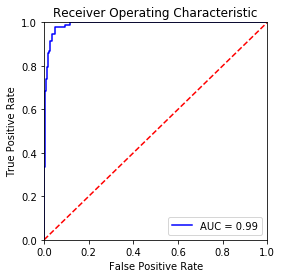

-1.03


0.35

In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# ROC-curve:
predprobs = logreg.predict_log_proba(test_vec)

fpr, tpr, thresholds = metrics.roc_curve(test_y, predprobs[:,1], pos_label='1')
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC: {}".format(round(roc_auc, 3)))
plt.figure(figsize=(4,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr,'b',label='AUC = %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ideal cutoff (Youden's J):
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
print(round(optimal_threshold, 2))

round(np.exp(-1.0461102494062424), 2) # ~0.35 -> we might be able to substantially lower the threshold!

Both the area under the curve as well as the ROC-curve look very nice. Looking at the ROC-curve, we can see that the optimal threshold should have a true positive rate of a little above .95. Youden's J gives us the optimal (logged) cutoff and - transforming it, we see that we could substantially lower the threshold to 0.35!

Let's train this new model and compare performance:

In [23]:
# new model:
predictions_new = np.where(predprobs[:,1] > optimal_threshold, '1', '0')
print('New model with threshold at ~ 0.35 vs. initial classifier:')
print('\nAccuracy: ' + 
      str(round(sklearn.metrics.accuracy_score(test_y, predictions_new), 2)) + 
      ' vs. ' + 
      str(round(sklearn.metrics.accuracy_score(test_y, test_pred), 2)) + 
      '\nPrecision: ' + 
      str(round(sklearn.metrics.precision_score(test_y, predictions_new, pos_label = '1'), 2)) + 
      ' vs. ' + 
      str(round(sklearn.metrics.precision_score(test_y, test_pred, pos_label = '1'), 2)) + 
      '\nRecall: ' + 
      str(round(sklearn.metrics.recall_score(test_y, predictions_new, pos_label = '1'), 2)) + 
      ' vs. ' + 
      str(round(sklearn.metrics.recall_score(test_y, test_pred, pos_label = '1'), 2)) + 
      '\nF1-score: ' + 
      str(round(sklearn.metrics.f1_score(test_y, predictions_new, pos_label = '1'), 2)) + 
      ' vs. ' + 
      str(round(sklearn.metrics.f1_score(test_y, test_pred, pos_label = '1'), 2)))

print(metrics.confusion_matrix(test_y, predictions_new))

New model with threshold at ~ 0.35 vs. initial classifier:

Accuracy: 0.95 vs. 0.96
Precision: 0.78 vs. 0.88
Recall: 0.97 vs. 0.86
F1-score: 0.86 vs. 0.87
[[480  25]
 [  3  89]]


We can see that we could manage to improve recall substantially, however at the price of precision (accuracy is slightly worse, f1 identical). The trade-off here is whether to be able to collect 10% more (nearly all) of the press releases on immigration at the price of 10% more wrongly classified releases that are not on immigration. I decide to go for very strong performance on both measures over exceptional recall and average precision and stick with the threshold of 0.5.

I am thrilled by the performance of my classifier, however - since we did not employ cross-validation for the training of this model - it might be overfitted. To check that the classifier is not guided by spurious relationships, we can visually inspect the best predictor words and check the classification of a press release using eli5:

In [33]:
# best predictor words:
import eli5
eli5.show_weights(logreg, top = 20, vec = vec_tfidf_f)

Weight?,Feature
+7.011,fluchtling
+5.765,integration
+4.468,ausland
+3.419,zuwander
+2.294,migrant
+2.075,kommun
+2.033,deutschland
+1.888,eu
+1.878,zuwanderungsgesetz
+1.804,spataussiedl


In [69]:
# example text
eli5.show_prediction(logreg, test[0][11][5], vec = vec_tfidf_f)

The visual inspection of the best predictor words underlines that the classifier does what it should. The best predictor words are all strongly related to migration. It does not seem like we have to worry about overfitting.

Lastly, the uncoded cases are predicted and everything is written into a single csv:

In [70]:
predictset = []
with open('C:/Users/samunico/OneDrive/Dokumente/Studium/Amsterdam/Studies/Semester 2/Block I/Big Data/FinalPaper/Releases/predict.csv', mode="r", encoding="utf-8") as predict:
    reader_predict = csv.reader(predict)
    for row in reader_predict:
        predictset.append(row[5])

pred_vec  = vec_tfidf_f.transform(predictset)
pred_yhat = logreg.predict(pred_vec)


with open(basedir + 'final_dataset.csv', mode="w", encoding="utf-8") as fo:
    with open(basedir + 'train.csv', mode="r", encoding="utf-8") as train:
        with open(basedir + 'test.csv', mode="r", encoding="utf-8") as test:
            with open(basedir + 'predict.csv', mode="r", encoding="utf-8") as predict:
                
                fieldnames = ['date', 'sender', 'title', 'link', 'raw', 'clean_full', 'clean_rest', 'coding']
                writer = csv.DictWriter(fo, lineterminator = '\n', fieldnames = fieldnames)
                writer.writeheader()
                
                reader_train   = csv.reader(train)
                reader_test    = csv.reader(test)
                reader_predict = csv.reader(predict)
                next(reader_train)
                
                # append prediction to uncoded cases, write to csv
                for row, p in zip(reader_predict, pred_yhat):
                    writer.writerow({'date':         row[0], 
                                     'sender':       row[1], 
                                     'title':        row[2], 
                                     'link':         row[3],
                                     'raw':          row[4],
                                     'clean_full':   row[5],
                                     'clean_rest':   row[6], 
                                     'coding':       p})
                        
                # add training set
                for row in reader_train:
                    writer.writerow({'date':         row[0], 
                                     'sender':       row[1], 
                                     'title':        row[2], 
                                     'link':         row[3],
                                     'raw':          row[4],
                                     'clean_full':   row[5],
                                     'clean_rest':   row[6], 
                                     'coding':       row[7]})
                
                # add test set
                for row in reader_test:
                    writer.writerow({'date':         row[0], 
                                     'sender':       row[1], 
                                     'title':        row[2], 
                                     'link':         row[3],
                                     'raw':          row[4],
                                     'clean_full':   row[5],
                                     'clean_rest':   row[6], 
                                     'coding':       row[7]})